In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_squared_log_error, median_absolute_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [10]:
data = pd.read_csv("C:/Users/mi/ml/notebooks/KR/data/diamonds.csv", sep=',')

In [11]:
del data['Unnamed: 0']
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [12]:
data.shape

(53940, 10)

In [13]:
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [14]:
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

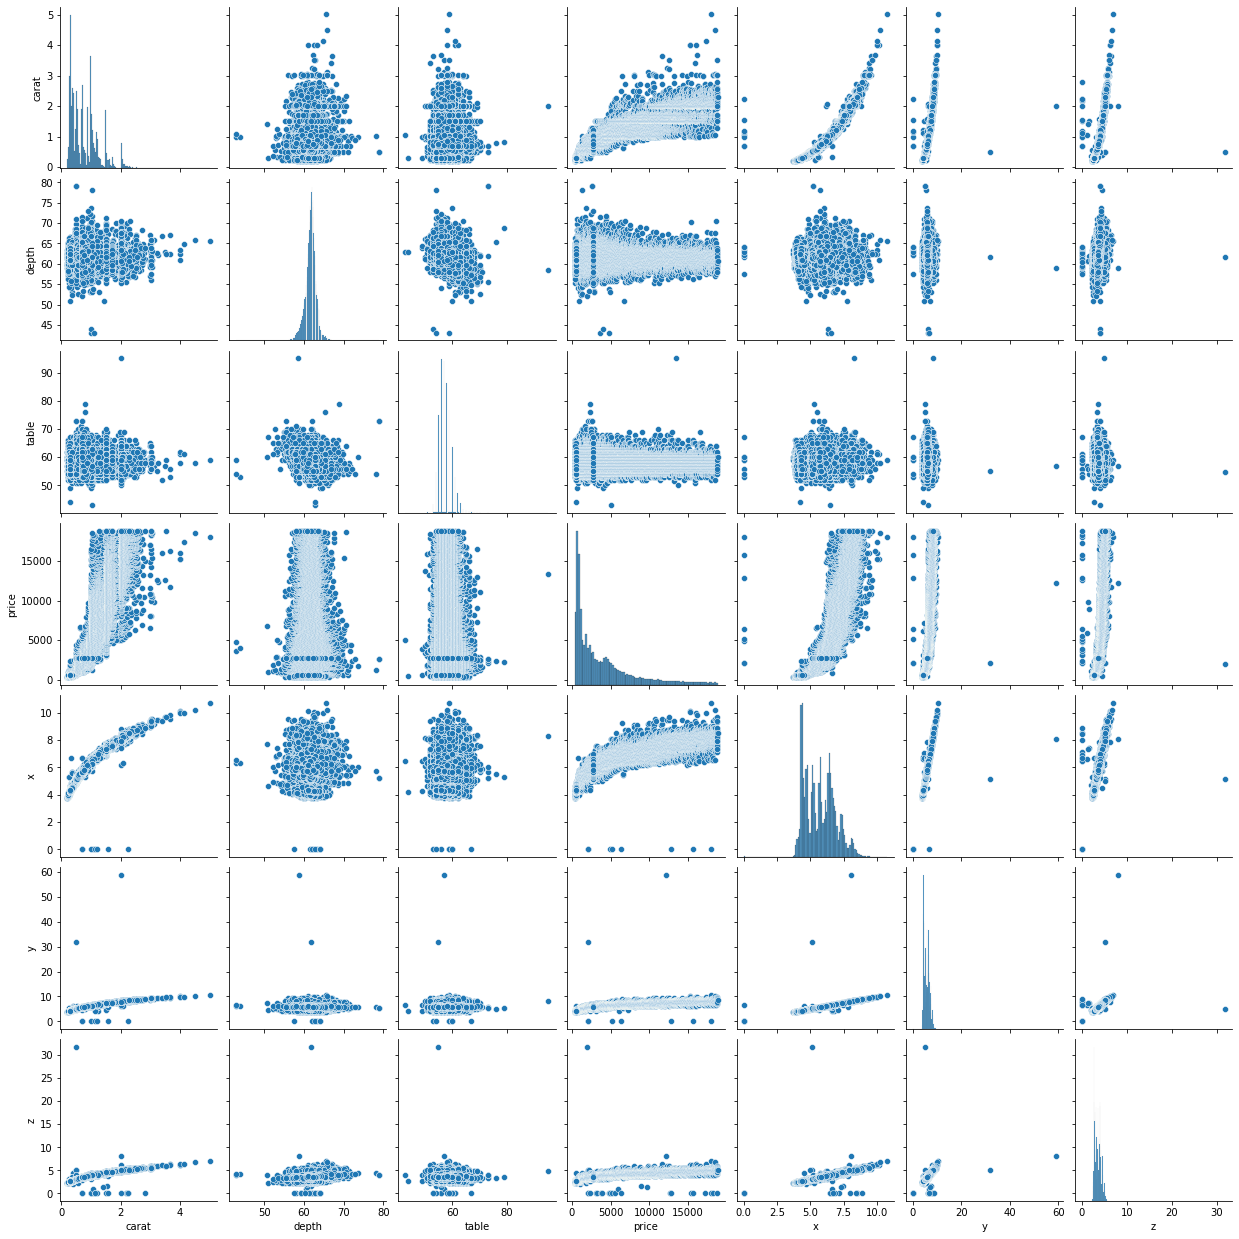

In [15]:
sns.pairplot(data)

In [16]:
data.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

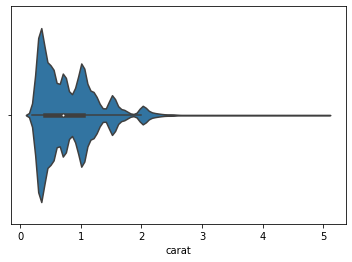

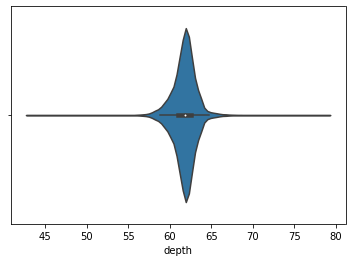

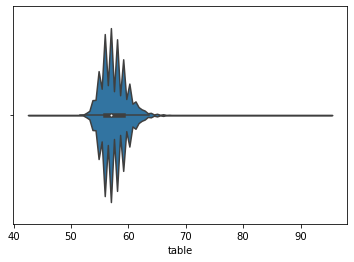

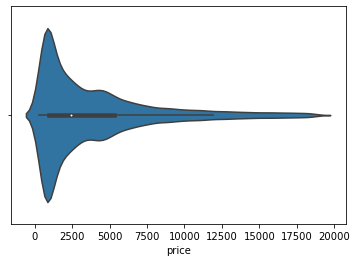

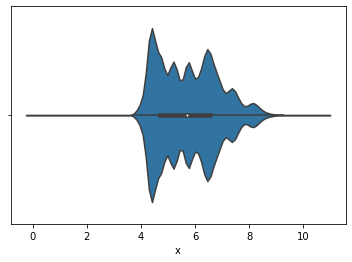

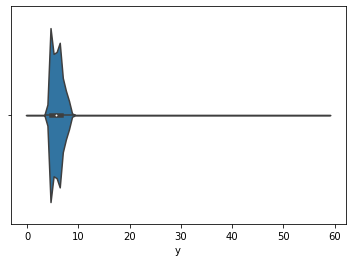

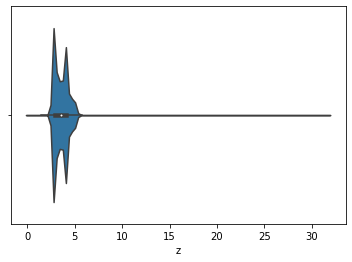

In [17]:
# Скрипичные диаграммы для числовых колонок
for col in ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']:
    sns.violinplot(x=data[col])
    plt.show()

In [19]:
scale_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
sc = MinMaxScaler()
sc_data = sc.fit_transform(data[scale_cols])

In [20]:
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = sc_data[:,i]

In [21]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_scaled,depth_scaled,table_scaled,x_scaled,y_scaled,z_scaled
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0.006237,0.513889,0.230769,0.367784,0.067572,0.076415
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,0.002079,0.466667,0.346154,0.362197,0.065195,0.072642
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,0.006237,0.386111,0.423077,0.377095,0.069100,0.072642
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,0.018711,0.538889,0.288462,0.391061,0.071817,0.082704
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,0.022869,0.563889,0.288462,0.404097,0.073854,0.086478


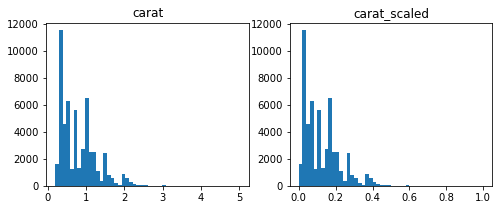

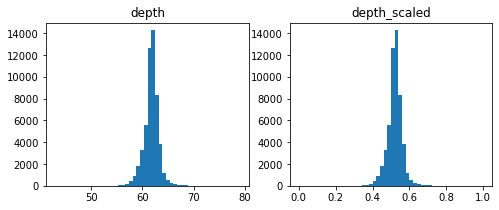

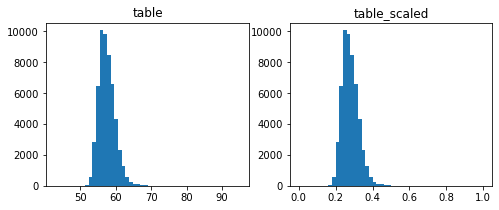

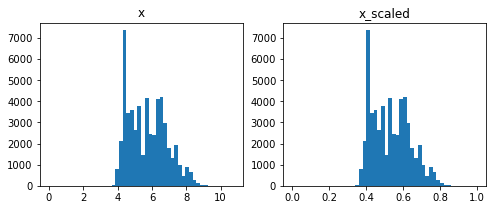

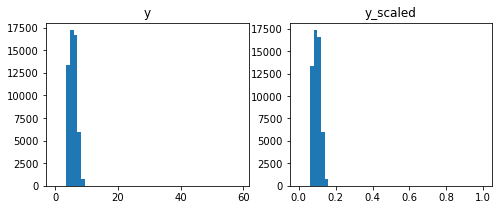

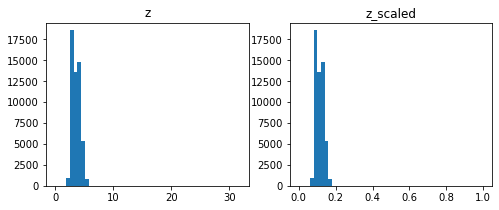

In [22]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'
    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

In [25]:
data.drop(scale_cols, axis=1, inplace=True)
data.head()

,cut,color,clarity,price,carat_scaled,x_scaled,y_scaled,z_scaled
0,Ideal,E,SI2,326,0.006237,0.367784,0.067572,0.076415
1,Premium,E,SI1,326,0.002079,0.362197,0.065195,0.072642
2,Good,E,VS1,327,0.006237,0.377095,0.069100,0.072642
3,Premium,I,VS2,334,0.018711,0.391061,0.071817,0.082704
4,Good,J,SI2,335,0.022869,0.404097,0.073854,0.086478


<AxesSubplot:>

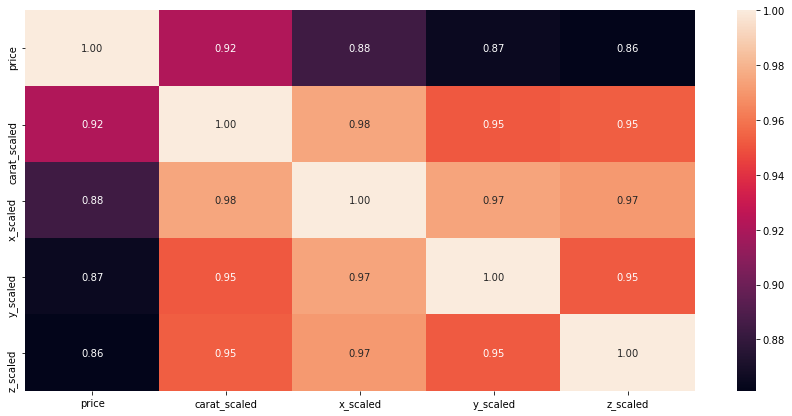

In [28]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

In [39]:
class MetricLogger:
    def __init__(self):
        self.df = pd.DataFrame(
        {'metric': pd.Series([], dtype='str'),
        'alg': pd.Series([], dtype='str'),
        'value': pd.Series([], dtype='float')})
    def add(self, metric, alg, value):
        """
        Добавление значения
        """# Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)
    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
        align='center',
        height=0.5,
        tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [40]:
data.columns

Index(['cut', 'color', 'clarity', 'price', 'carat_scaled', 'x_scaled',
       'y_scaled', 'z_scaled'],
      dtype='object')

In [41]:
feature_cols = ['carat_scaled', 'x_scaled', 'y_scaled', 'z_scaled']
data_X = data.loc[:, feature_cols]
data_Y = data.loc[:, 'price']
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data_X, data_Y,test_size=0.2, random_state=1)

In [42]:
# Модели
regr_models = {'LR': LinearRegression(),
'KNN_1':KNeighborsRegressor(n_neighbors=1),
'LinearSVR':LinearSVR(C=1.0),
'Tree':DecisionTreeRegressor(),
'RF':RandomForestRegressor(),
'GB':GradientBoostingRegressor()}

In [43]:
# Сохранение метрик
regrMetricLogger = MetricLogger()

In [44]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(data_X_train, data_y_train)
    y_pred = model.predict(data_X_test)
    mae = mean_absolute_error(data_y_test, y_pred)
    mse = mean_squared_error(data_y_test, y_pred)
    r2 = r2_score(data_y_test, y_pred)
    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)
    print('{} \t MAE={}, MSE={}, R2={}'.format(
    model_name, round(mae, 3), round(mse, 3), round(r2, 3)))

In [45]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

LR 	 MAE=912.73, MSE=2257937.95, R2=0.855
KNN_1 	 MAE=1031.982, MSE=3352166.464, R2=0.784
LinearSVR 	 MAE=2194.064, MSE=12991435.58, R2=0.164
Tree 	 MAE=1070.454, MSE=3705029.787, R2=0.762
RF 	 MAE=824.646, MSE=2058491.674, R2=0.868
GB 	 MAE=786.261, MSE=1821653.384, R2=0.883


In [46]:
kn_n_range = np.array(range(1,15,1))
kn_tuned_parameters = [{'n_neighbors': kn_n_range}]
kn_tuned_parameters

[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}]

In [48]:
%%time
gs_kn = GridSearchCV(KNeighborsRegressor(), kn_tuned_parameters, cv=5, scoring='neg_mean_squared_error')
gs_kn.fit(data_X_train, data_y_train)

Wall time: 19.9 s


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}],
             scoring='neg_mean_squared_error')

In [49]:
# Лучшая модель
gs_kn.best_estimator_

KNeighborsRegressor(n_neighbors=14)

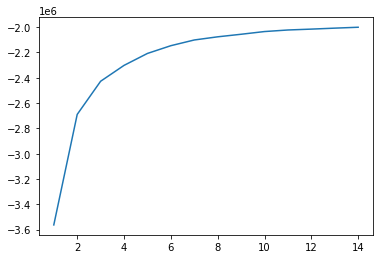

In [50]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(kn_n_range, gs_kn.cv_results_['mean_test_score'])

In [51]:
lsvr_c_range = np.array(range(1,100000, 10000))
lsvr_tuned_parameters = [{'C': lsvr_c_range}]
lsvr_tuned_parameters

[{'C': array([    1, 10001, 20001, 30001, 40001, 50001, 60001, 70001, 80001,
         90001])}]

In [52]:
%%time
gs_lsvr = GridSearchCV(LinearSVR(), lsvr_tuned_parameters, cv=5, scoring='neg_mean_squared_error')
gs_lsvr.fit(data_X_train, data_y_train)

C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.wa

C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.wa

Wall time: 1min 27s


C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=5, estimator=LinearSVR(),
             param_grid=[{'C': array([    1, 10001, 20001, 30001, 40001, 50001, 60001, 70001, 80001,
       90001])}],
             scoring='neg_mean_squared_error')

In [53]:
# Лучшая модель
gs_lsvr.best_estimator_

LinearSVR(C=10001)

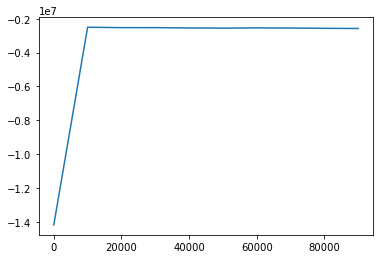

In [54]:
# Изменение качества на тестовой выборке в зависимости от C
plt.plot(lsvr_c_range, gs_lsvr.cv_results_['mean_test_score'])

In [55]:
tree_depth_range = np.array(range(3,11,1))
tree_tuned_parameters = [{'max_depth': tree_depth_range}]
tree_tuned_parameters

[{'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10])}]

In [56]:
%%time
gs_tree = GridSearchCV(DecisionTreeRegressor(), tree_tuned_parameters, cv=5, scoring='neg_mean_squared_error')
gs_tree.fit(data_X_train, data_y_train)

Wall time: 3.96 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10])}],
             scoring='neg_mean_squared_error')

In [57]:
# Лучшая модель
gs_tree.best_estimator_

DecisionTreeRegressor(max_depth=6)

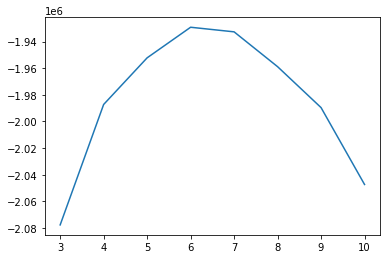

In [58]:
# Изменение качества на тестовой выборке в зависимости от глубины дерева
plt.plot(tree_depth_range, gs_tree.cv_results_['mean_test_score'])

In [59]:
rf_n_range = np.array(range(200,500,100))
rf_tuned_parameters = [{'n_estimators': rf_n_range}]
rf_tuned_parameters

[{'n_estimators': array([200, 300, 400])}]

In [61]:
%%time
gs_rf = GridSearchCV(RandomForestRegressor(), rf_tuned_parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_rf.fit(data_X_train, data_y_train)

Wall time: 4min 6s


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'n_estimators': array([200, 300, 400])}],
             scoring='neg_mean_squared_error')

In [62]:
# Лучшая модель
gs_rf.best_estimator_

RandomForestRegressor(n_estimators=400)

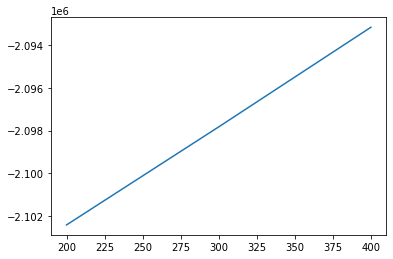

In [63]:
# Изменение качества на тестовой выборке в зависимости от n_estimators
plt.plot(rf_n_range, gs_rf.cv_results_['mean_test_score'])

In [65]:
%%time
gs_gb = GridSearchCV(GradientBoostingRegressor(), rf_tuned_parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_gb.fit(data_X_train, data_y_train)

Wall time: 1min 2s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'n_estimators': array([200, 300, 400])}],
             scoring='neg_mean_squared_error')

In [66]:
# Лучшая модель
gs_gb.best_estimator_

GradientBoostingRegressor(n_estimators=300)

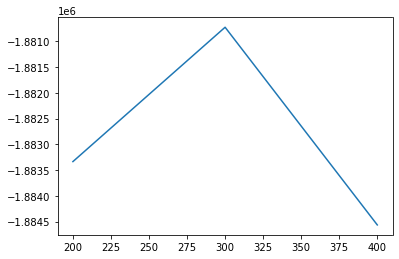

In [67]:
# Изменение качества на тестовой выборке в зависимости от n_estimators
plt.plot(rf_n_range, gs_gb.cv_results_['mean_test_score'])

In [68]:
regr_models_grid = {
'KNN(best)':gs_kn.best_estimator_,
'Tree(best)':gs_tree.best_estimator_,
'LinearSVR(best)':gs_lsvr.best_estimator_,
'RF(best)':gs_rf.best_estimator_,
'GB(best)':gs_gb.best_estimator_
}

In [69]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

KNN(best) 	 MAE=803.387, MSE=1950463.441, R2=0.874
Tree(best) 	 MAE=797.158, MSE=1891416.58, R2=0.878


C:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(best) 	 MAE=836.215, MSE=2326772.027, R2=0.85
RF(best) 	 MAE=821.689, MSE=2044474.57, R2=0.868
GB(best) 	 MAE=777.454, MSE=1790089.485, R2=0.885


In [70]:
# Метрики качества модели
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

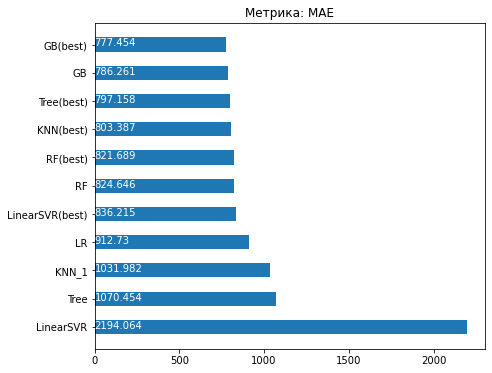

In [71]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 6))

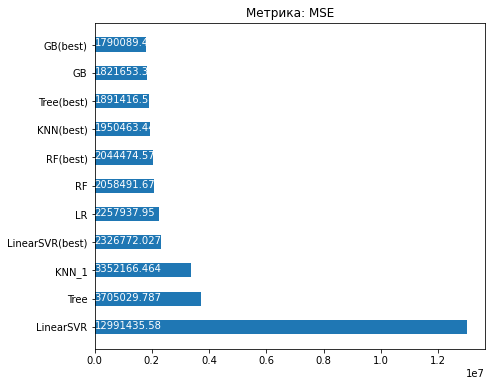

In [72]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(7, 6))

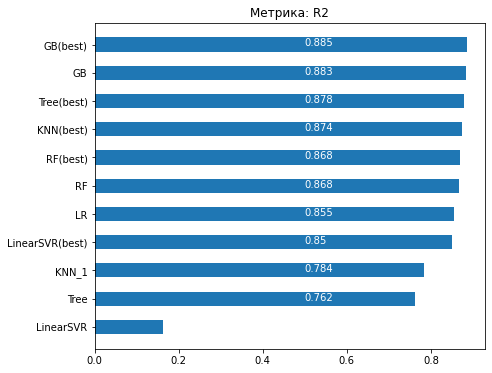

In [73]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))